<a href="https://colab.research.google.com/github/adihatake/Improving-OCT-Interpretation-through-Retrieval-Guided-Diagnosis-and-LLM-Based-Reporting/blob/main/Indicium_ResNet50_RAG_Demo_and_Case_Evaluations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README!
**Cells required to execute:**
1. Load the dependencies, model and FAISS index
2. Setup LangChain
3. Use Gradio
---





# Load dependencies, model and FAISS index
Can take a couple minutes to load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install faiss-cpu
! pip install datasets
! pip install langchain-community
! pip install -U langchain-google-genai
! pip install torchcam

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import datasets
import numpy as np
import random
import faiss
import os
import PIL
import gradio as gr



from PIL import Image
from datasets import load_dataset, load_from_disk

from torch.utils.data import DataLoader
from torchvision import transforms


from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image


from langchain_community.vectorstores import FAISS
from langchain_core.embeddings import Embeddings
from langchain.schema import Document
from langchain.chat_models import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.docstore import InMemoryDocstore



# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)



label_map = {0: "DR", 1: "DME"}
biomarker_fields = [
    "Atrophy / thinning of retinal layers",
    "Disruption of EZ",
    "DRIL",
    "IR hemorrhages",
    "IR HRF",
    "Partially attached vitreous face",
    "Fully attached vitreous face",
    "Preretinal tissue/hemorrhage",
    "Vitreous debris",
    "VMT",
    "DRT/ME",
    "Fluid (IRF)",
    "Fluid (SRF)",
    "Disruption of RPE",
    "PED (serous)",
    "SHRM"
]

biomarker_targets = [
    "Fluid (IRF)",
    "Partially attached vitreous face",
    "Fully attached vitreous face",
    "IR HRF",
    "DRT/ME",
    "Vitreous debris"
]

biomarker_display_names = {
    "Fluid (IRF)": "Intraretinal Fluid",
    "Partially attached vitreous face": "Partially attached vitreous face",
    "Fully attached vitreous face": "Fully attached vitreous face",
    "IR HRF": "Intraretinal Hyperreflective Foci",
    "DRT/ME": "Diffuse Retinal Thickening or Diabetic Macular Edema (DR/ME)",
    "Vitreous debris": "Vitreous Debris (VD)"
}

Define model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

class OCT_net(nn.Module):
    def __init__(self, num_biomarkers=16, num_diseases=2):
        super().__init__()

        # Load pre-trained ResNet50 and replace FC with identity
        pre_trained_model = resnet50(weights=ResNet50_Weights.DEFAULT)
        pre_trained_model.fc = nn.Identity()


        self.backbone = pre_trained_model
        self.feature_dim = 2048  # Output of resnet50 with identity FC

        # Biomarker regression head
        self.biomarker_head = nn.Sequential(
            nn.Linear(self.feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_biomarkers)
        )

        # Disease classification head
        self.disease_head = nn.Sequential(
            nn.Linear(self.feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_diseases)
        )

    def forward(self, x, return_features=False, head=None):
        x = self.backbone(x)  # Shape: (B, 2048)

        biomarker_logits = self.biomarker_head(x)
        disease_logits = self.disease_head(x)

        if return_features:
            biomarker_feats = self.biomarker_head[:-1](x)
            disease_feats = self.disease_head[:-1](x)
            combined = torch.cat([biomarker_feats, disease_feats], dim=1)
            embedding = F.normalize(combined, dim=1, p=2)
            return biomarker_logits, disease_logits, embedding

        if head == 'biomarker':
            return biomarker_logits
        elif head == 'disease':
            return disease_logits

        return biomarker_logits, disease_logits

In [ ]:
# Check the device to either enable CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load checkpoint
checkpoint_path = "/content/drive/MyDrive/Indicium/model_checkpoints/Jun_21_augmentations_finetuning/model_epoch_8.pth"  # or whichever checkpoint we want
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load the model's state dictionary, weights, gradients and optimizer
model = OCT_net()
model.load_state_dict(checkpoint['model_state_dict'])

# put model to device
model.to(device)




Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 412MB/s]


OCT_net(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [ ]:
save_dir = "/content/drive/MyDrive/Indicium/FAISS_indexes/Jun_21_Jun21-epoch18-finetuned"
index = faiss.read_index(f"{save_dir}/oct_features.index")
labels = np.load(f"{save_dir}/oct_labels.npy", allow_pickle=True)
biomarkers = np.load(f"{save_dir}/oct_biomarkers.npy", allow_pickle=True)

# Setup LangChain

In [ ]:
# Define transforms for validation and test datasets
resnet_transform = transforms.Compose([
    transforms.Resize(256),                        # Resize shorter side to 256
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.ToTensor(),                 # Converts to [C, H, W] in range [0, 1]
    transforms.Normalize(                  # Standard ImageNet normalization
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])



# using a dummy embedding for now
class DummyEmbeddings(Embeddings):
    def embed_documents(self, texts):
        raise NotImplementedError("Not used here.")

    def embed_query(self, text):
        raise NotImplementedError("Use a real embedding model for querying.")


# Extract features from image
def extract_logit_vector(image_path, require_grad=False):
    img = PIL.Image.open(image_path)
    transformed_img = resnet_transform(img)

    input_image = transformed_img.to(device).unsqueeze(0)


    model.eval()

    if require_grad == True:
      with torch.enable_grad():
        biomarker_logits, disease_logits = model(input_image)

      return biomarker_logits, disease_logits

    elif require_grad == False:
      with torch.no_grad():
        biomarker_logits, disease_logits, features = model(input_image, return_features=True)  # shape: 256

      return biomarker_logits, disease_logits, features.cpu().numpy().astype("float32")



# Create langchain document with provided metadata
def create_lc_document(vector, metadata_dict):
    return Document(page_content="OCT scan features", metadata=metadata_dict), vector


In [ ]:
#  build the FAISS vectorstore with example OCT cases
disease_mapping = {0: "DR", 1: "DME"}

doc_list = []
for i in range(len(labels)):

    doc = Document(
        page_content="OCT scan features",
        metadata={
            "image_id": f"Scan {i+1}",
            "label": str(disease_mapping[labels[i]]),
            "biomarkers": dict(zip(biomarker_fields, biomarkers[i].tolist()))
        }
    )
    doc_list.append(doc)

print(doc_list)

[Document(metadata={'image_id': 'Scan 1', 'label': 'DME', 'biomarkers': {'Atrophy / thinning of retinal layers': 0.0, 'Disruption of EZ': 0.0, 'DRIL': 0.0, 'IR hemorrhages': 0.0, 'IR HRF': 1.0, 'Partially attached vitreous face': 1.0, 'Fully attached vitreous face': 0.0, 'Preretinal tissue/hemorrhage': 0.0, 'Vitreous debris': 0.0, 'VMT': 0.0, 'DRT/ME': 0.0, 'Fluid (IRF)': 0.0, 'Fluid (SRF)': 0.0, 'Disruption of RPE': 0.0, 'PED (serous)': 0.0, 'SHRM': 0.0}}, page_content='OCT scan features'), Document(metadata={'image_id': 'Scan 2', 'label': 'DR', 'biomarkers': {'Atrophy / thinning of retinal layers': 0.0, 'Disruption of EZ': 0.0, 'DRIL': 0.0, 'IR hemorrhages': 0.0, 'IR HRF': 0.0, 'Partially attached vitreous face': 0.0, 'Fully attached vitreous face': 1.0, 'Preretinal tissue/hemorrhage': 0.0, 'Vitreous debris': 1.0, 'VMT': 0.0, 'DRT/ME': 0.0, 'Fluid (IRF)': 0.0, 'Fluid (SRF)': 0.0, 'Disruption of RPE': 0.0, 'PED (serous)': 0.0, 'SHRM': 0.0}}, page_content='OCT scan features'), Document

In [ ]:
#vectorstore = FAISS.from_documents(doc_list, embedding=PassThroughEmbedding())
#vectorstore = FAISS(embedding_function=PassThroughEmbedding(), index=index, docs=doc_list)

docstore = InMemoryDocstore({str(i): doc for i, doc in enumerate(doc_list)})

vectorstore = FAISS(
    index=index,
    docstore=docstore,
    index_to_docstore_id={i: str(i) for i in range(len(doc_list))},
    embedding_function=DummyEmbeddings()
)

In [ ]:
# Now we can run LangChain to generate the diagnosis


os.environ["GOOGLE_API_KEY"] = ""

# Instantiate Gemini LLM
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")

prompt = PromptTemplate(
    input_variables=["cases", "current"],
    template="""


Current predictions: {current}

Similar cases
{cases}

Using information from similar cases and the current predictions, determine a diagnosis for the patient.
Additionally, determine possible biomarkers.


Only provide me a clinical report taking the following format:

******
Clinical Report
******

Final diagnosis:diagnosis
B1: biomarker
B2: biomarker
... etc

Explanation:

List the similar cases



"""
)


# GradCam Visualization (requires manually inputting the image and desired class)


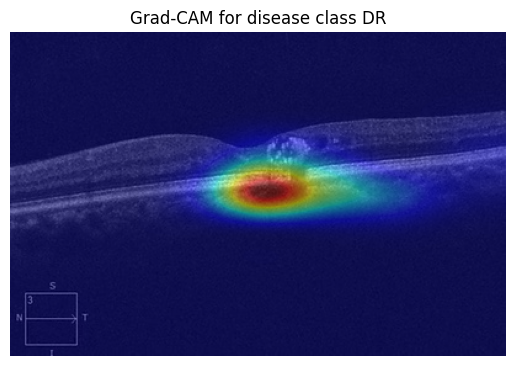

In [ ]:
# Pick the target layer (last conv layer of ResNet50)
target_layer = model.backbone.layer4[-1]
# Attach GradCAM
cam_extractor = GradCAM(model, target_layer=target_layer)

biomarker_logits, disease_logits = extract_logit_vector('test_case2.jpg', require_grad=True)

# Pick a class index. Either {0: "DR", 1: "DME"}
class_idx = 0

# Compute CAM (automatically does backward)
activation_map = cam_extractor(class_idx, disease_logits)

input_img = PIL.Image.open('test_case2.jpg').convert('RGB')

# Overlay the activation map
result = overlay_mask(input_img, to_pil_image(activation_map[0].squeeze(), mode='F'), alpha=0.5)

# Show the result
plt.imshow(result)
plt.title(f"Grad-CAM for disease class DR")
plt.axis('off')
plt.show()


# Define our RAG Function

In [ ]:
chain = LLMChain(prompt=prompt, llm=llm)


def diagnose_from_image(image):
    # Feature extraction
    biomarker_logits, disease_logits, new_scan_vector = extract_logit_vector(image)


    new_scan_vector = new_scan_vector.flatten()
    biomarker_probs = torch.sigmoid(biomarker_logits).squeeze().cpu().numpy()
    disease_probs = F.softmax(disease_logits, dim=1).squeeze().cpu().numpy()

    # Similarity search
    top_k_similar = vectorstore.similarity_search_by_vector(new_scan_vector, k=5)

    similar_cases_str = ""
    for i, doc in enumerate(top_k_similar):
        m = doc.metadata
        b = m["biomarkers"]
        similar_cases_str += (
            f"Scan {i+1}: Label = {m['label']}, Biomarkers = "
            f"Intraretinal Fluid: {b['Fluid (IRF)']}, "
            f"Partially attached vitreous face: {b['Partially attached vitreous face']}, "
            f"Fully attached vitreous face: {b['Fully attached vitreous face']}, "
            f"Intraretinal Hyperreflective Foci: {b['IR HRF']}, "
            f"Diffuse Retinal Thickening or Diabetic Macular Edema (DR/ME): {b['DRT/ME']}, "
            f"Vitreous Debris (VD): {b['Vitreous debris']}\n"
        )

    # Diagnosis and biomarker summary
    label_idx = np.argmax(disease_probs)
    label = label_map[label_idx]
    label_probs_str = ", ".join([f"{label_map[i]}: {prob:.3f}" for i, prob in enumerate(disease_probs)])
    biomarker_dict = {field: prob for field, prob in zip(biomarker_fields, biomarker_probs)}
    biomarkers_str = ", ".join([
        f"{biomarker_display_names[field]}: {biomarker_dict[field]:.3f}"
        for field in biomarker_targets
    ])
    current_case_str = f"Labels: {label} ({label_probs_str}), Biomarkers: {biomarkers_str}"

    print(similar_cases_str)


    # Generate report
    output = chain.run({
        "cases": similar_cases_str,
        "current": current_case_str
    })

    return output, similar_cases_str, current_case_str


In [ ]:
#output, similar, current_case = diagnose_from_image('test_case2.jpg')

Scan 1: Label = DR, Biomarkers = Intraretinal Fluid: 1.0, Partially attached vitreous face: 0.0, Fully attached vitreous face: 1.0, Intraretinal Hyperreflective Foci: 0.0, Diffuse Retinal Thickening or Diabetic Macular Edema (DR/ME): 0.0, Vitreous Debris (VD): 0.0
Scan 2: Label = DME, Biomarkers = Intraretinal Fluid: 1.0, Partially attached vitreous face: 0.0, Fully attached vitreous face: 1.0, Intraretinal Hyperreflective Foci: 1.0, Diffuse Retinal Thickening or Diabetic Macular Edema (DR/ME): 1.0, Vitreous Debris (VD): 0.0
Scan 3: Label = DR, Biomarkers = Intraretinal Fluid: 1.0, Partially attached vitreous face: 0.0, Fully attached vitreous face: 1.0, Intraretinal Hyperreflective Foci: 1.0, Diffuse Retinal Thickening or Diabetic Macular Edema (DR/ME): 1.0, Vitreous Debris (VD): 0.0
Scan 4: Label = DR, Biomarkers = Intraretinal Fluid: 1.0, Partially attached vitreous face: 1.0, Fully attached vitreous face: 0.0, Intraretinal Hyperreflective Foci: 1.0, Diffuse Retinal Thickening or Di

/tmp/ipython-input-14-3909453767.py:45: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  output = chain.run({


In [ ]:
#print(similar)

Scan 1: Label = DR, Biomarkers = Intraretinal Fluid: 1.0, Partially attached vitreous face: 0.0, Fully attached vitreous face: 1.0, Intraretinal Hyperreflective Foci: 0.0, Diffuse Retinal Thickening or Diabetic Macular Edema (DR/ME): 0.0, Vitreous Debris (VD): 0.0
Scan 2: Label = DME, Biomarkers = Intraretinal Fluid: 1.0, Partially attached vitreous face: 0.0, Fully attached vitreous face: 1.0, Intraretinal Hyperreflective Foci: 1.0, Diffuse Retinal Thickening or Diabetic Macular Edema (DR/ME): 1.0, Vitreous Debris (VD): 0.0
Scan 3: Label = DR, Biomarkers = Intraretinal Fluid: 1.0, Partially attached vitreous face: 0.0, Fully attached vitreous face: 1.0, Intraretinal Hyperreflective Foci: 1.0, Diffuse Retinal Thickening or Diabetic Macular Edema (DR/ME): 1.0, Vitreous Debris (VD): 0.0
Scan 4: Label = DR, Biomarkers = Intraretinal Fluid: 1.0, Partially attached vitreous face: 1.0, Fully attached vitreous face: 0.0, Intraretinal Hyperreflective Foci: 1.0, Diffuse Retinal Thickening or Di

In [ ]:
#print(current_case)

Labels: DR (DR: 0.732, DME: 0.268), Biomarkers: Intraretinal Fluid: 0.774, Partially attached vitreous face: 0.453, Fully attached vitreous face: 0.489, Intraretinal Hyperreflective Foci: 0.888, Diffuse Retinal Thickening or Diabetic Macular Edema (DR/ME): 0.657, Vitreous Debris (VD): 0.325


# Use Gradio

In [ ]:

# Gradio UI
iface = gr.Interface(
    fn=diagnose_from_image,
    inputs=gr.Image(type="filepath", label="Upload Medical Image"),
    outputs=gr.Textbox(label="Generated Clinical Report"),
    title="OCT Imaging Diagnosis Assistant",
    description="Upload a scan image to generate a clinical report using similarity search and LLM-based reasoning."
)

iface.launch(share=True)
